Kelompok


*   Ade Ripaldi Nuralim
*   Dimas Arya Nurhakim
*   Alya nurul lathifah







In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Unzip dataset
dataset_path = "/content/drive/MyDrive/mesin/clasification_dataset/monggo.zip"

Mounted at /content/drive


In [ ]:
# Ekstrak file zip
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

# Pastikan dataset berhasil diekstrak
print("Ekstraksi selesai. File tersedia di /content/dataset")

Ekstraksi selesai. File tersedia di /content/dataset


In [ ]:
# Melihat isi folder dataset
dataset_dir = "/content/dataset"
print("Folder dalam dataset:", os.listdir(dataset_dir))


Folder dalam dataset: ['Cutting Weevil', 'Sooty Mould', 'Healthy', 'Bacterial Canker', 'Die Back', 'Gall Midge', 'Anthracnose', 'Powdery Mildew']


In [ ]:
total = sum(len(os.listdir(os.path.join(dataset_dir, label))) for label in os.listdir(dataset_dir))
print(f"\nTotal dataset: {total}")


Total dataset: 4000


In [ ]:
train_dir = "/content/dataset_split/train"
val_dir = "/content/dataset_split/val"
test_dir = "/content/dataset_split/test"

from sklearn.model_selection import train_test_split
import shutil

def split_dataset(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    labels = os.listdir(source_dir)
    for label in labels:
        img_paths = [os.path.join(source_dir, label, fname) for fname in os.listdir(os.path.join(source_dir, label))]
        train_files, temp_files = train_test_split(img_paths, train_size=split_ratio[0], shuffle=True)
        val_files, test_files = train_test_split(temp_files, test_size=split_ratio[2]/(split_ratio[1]+split_ratio[2]))

        for path_set, target_dir in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
            label_dir = os.path.join(target_dir, label)
            os.makedirs(label_dir, exist_ok=True)
            for file in path_set:
                shutil.copy(file, label_dir)

# Jalankan fungsi split
split_dataset("/content/dataset", train_dir, val_dir, test_dir)

In [ ]:
pip install tensorflow-hub

In [ ]:
# Step 1: Konfigurasi konsisten
img_size = (224, 224)
input_shape = (224, 224, 3)
batch_size = 32

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenet)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenet)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = train_generator.num_classes


Found 2800 images belonging to 8 classes.
Found 600 images belonging to 8 classes.
Found 600 images belonging to 8 classes.


In [ ]:
def build_model(base_model, input_shape, num_classes, freeze=True):
    base_model.trainable = not freeze
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
!pip install keras_applications

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.applications import NASNetMobile

In [ ]:
mobilenet_model = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape), input_shape, num_classes)
efficientnet_model = build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape), input_shape, num_classes)
nasnet_model = build_model(NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape), input_shape, num_classes)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nasnet


# EfficientNet - pakai preprocessing khusus
train_generator_eff = ImageDataGenerator(preprocessing_function=preprocess_efficientnet).flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator_eff = ImageDataGenerator(preprocessing_function=preprocess_efficientnet).flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

history_efficientnet = efficientnet_model.fit(train_generator_eff, validation_data=val_generator_eff, epochs=10)

# MobileNet
train_generator.preprocessing_function = preprocess_mobilenet
val_generator.preprocessing_function = preprocess_mobilenet
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=val_generator, epochs=10)

# NASNet
train_generator.preprocessing_function = preprocess_nasnet
val_generator.preprocessing_function = preprocess_nasnet
history_nasnet = nasnet_model.fit(train_generator, validation_data=val_generator, epochs=10)


Found 2800 images belonging to 8 classes.
Found 600 images belonging to 8 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 325ms/step - accuracy: 0.6568 - loss: 1.1472 - val_accuracy: 0.9700 - val_loss: 0.2347
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9731 - loss: 0.2075 - val_accuracy: 0.9783 - val_loss: 0.1240
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9865 - loss: 0.1157 - val_accuracy: 0.9850 - val_loss: 0.0826
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9891 - loss: 0.0913 - val_accuracy: 0.9900 - val_loss: 0.0632
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9931 - loss: 0.0635 - val_accuracy: 0.9883 - val_loss: 0.0525
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9922 - loss: 0.0536 - val_accuracy: 0.9933 - val_loss: 0.0420
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9937 - loss: 0.0484 - val_accuracy: 0.9933 - val_loss: 0.0360
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9971 - loss: 0.0346 - val_accuracy: 0.9933 - val_loss

In [ ]:
# Test Generator masing-masing model
test_generator_mob = ImageDataGenerator(preprocessing_function=preprocess_mobilenet).flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_generator_eff = ImageDataGenerator(preprocessing_function=preprocess_efficientnet).flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_generator_nas = ImageDataGenerator(preprocessing_function=preprocess_nasnet).flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Evaluasi
loss_mob, acc_mob = mobilenet_model.evaluate(test_generator_mob, verbose=0)
loss_eff, acc_eff = efficientnet_model.evaluate(test_generator_eff, verbose=0)
loss_nas, acc_nas = nasnet_model.evaluate(test_generator_nas, verbose=0)

print(f"✅ Test Accuracy:")
print(f"MobileNetV2     : {acc_mob:.4f}")
print(f"EfficientNet-B0 : {acc_eff:.4f}")
print(f"NASNetMobile    : {acc_nas:.4f}")


Found 600 images belonging to 8 classes.
Found 600 images belonging to 8 classes.
Found 600 images belonging to 8 classes.
✅ Test Accuracy:
MobileNetV2     : 0.9933
EfficientNet-B0 : 0.9867
NASNetMobile    : 0.9700


 **Plot Accuracy dan Loss per Epoch**

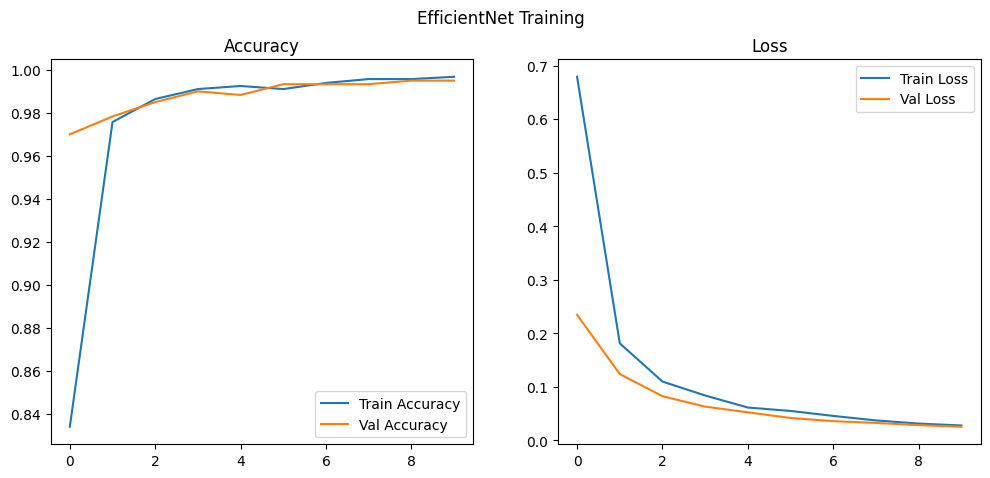

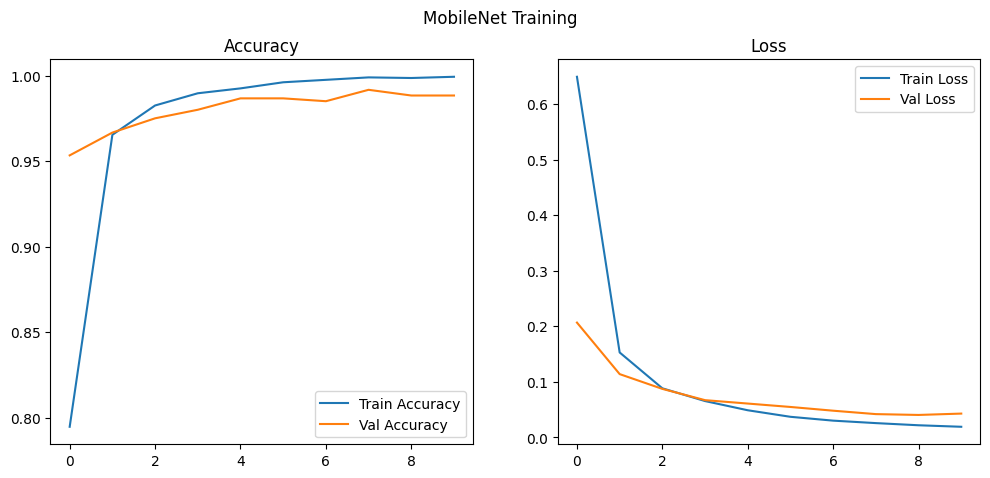

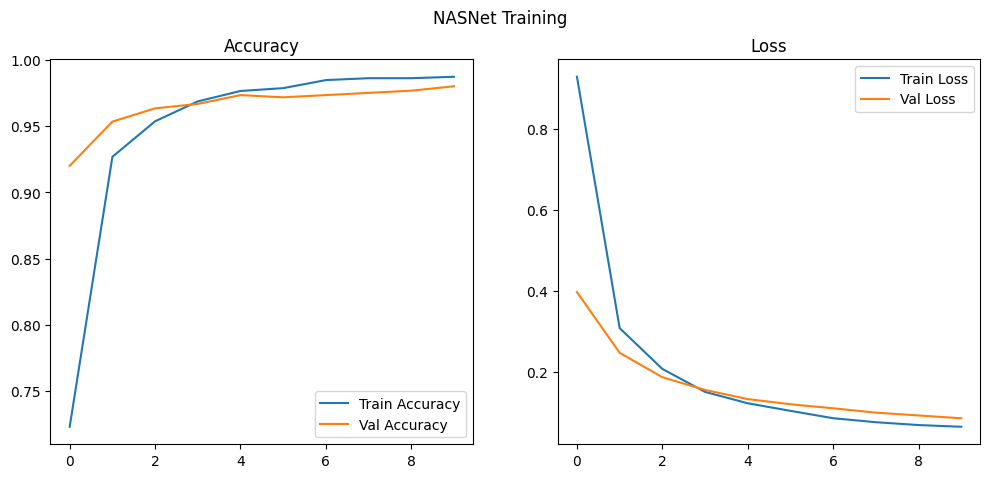

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()

# panggil
plot_history(history_efficientnet, 'EfficientNet Training')
plot_history(history_mobilenet, 'MobileNet Training')
plot_history(history_nasnet, 'NASNet Training')


**Confusion Matrix dan Classification Report efficienetb0**

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
Classification Report: EfficientNet
                   precision    recall  f1-score   support

     Anthracnose       0.99      0.99      0.99        75
Bacterial Canker       1.00      1.00      1.00        75
  Cutting Weevil       1.00      1.00      1.00        75
        Die Back       1.00      1.00      1.00        75
      Gall Midge       1.00      0.97      0.99        75
         Healthy       0.99      1.00      0.99        75
  Powdery Mildew       0.99      0.95      0.97        75
     Sooty Mould       0.94      0.99      0.96        75

        accuracy                           0.99       600
       macro avg       0.99      0.99      0.99       600
    weighted avg       0.99      0.99      0.99       600



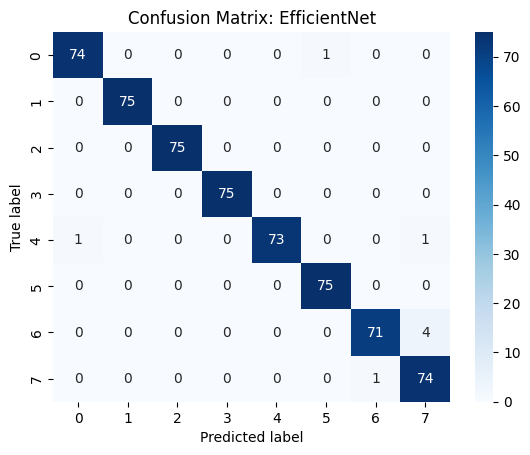

In [ ]:
y_pred_eff = efficientnet_model.predict(test_generator_eff)
y_pred_classes_eff = np.argmax(y_pred_eff, axis=1)
y_true_eff = test_generator_eff.classes

# confusion matrix dan classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm_eff = confusion_matrix(y_true_eff, y_pred_classes_eff)
cr_eff = classification_report(y_true_eff, y_pred_classes_eff, target_names=test_generator_eff.class_indices.keys())
print("Classification Report: EfficientNet\n", cr_eff)

sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: EfficientNet")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


 **Confusion Matrix & Classification Report: MobileNetV2**

Found 600 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
📊 Classification Report: MobileNetV2
                  precision    recall  f1-score   support

     Anthracnose       0.99      0.99      0.99        75
Bacterial Canker       0.99      0.99      0.99        75
  Cutting Weevil       1.00      1.00      1.00        75
        Die Back       1.00      1.00      1.00        75
      Gall Midge       0.99      0.99      0.99        75
         Healthy       1.00      1.00      1.00        75
  Powdery Mildew       1.00      0.99      0.99        75
     Sooty Mould       0.99      1.00      0.99        75

        accuracy                           0.99       600
       macro avg       0.99      0.99      0.99       600
    weighted avg       0.99      0.99      0.99       600



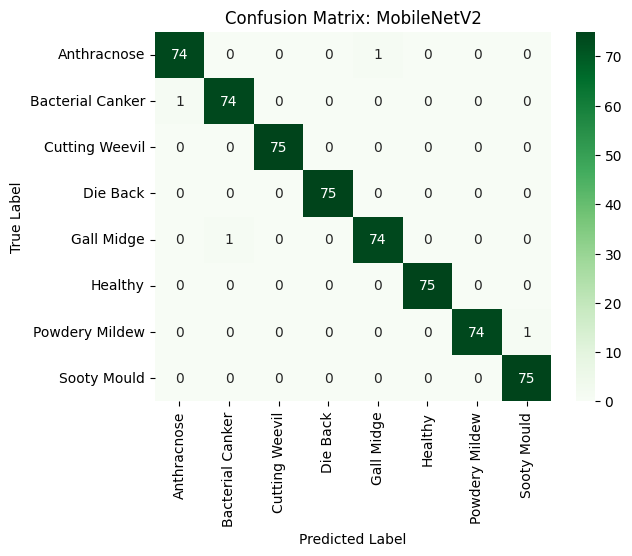

In [ ]:
# Test generator untuk MobileNetV2
test_generator_mob = ImageDataGenerator(preprocessing_function=preprocess_mobilenet).flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Prediksi dan label
y_pred_mob = mobilenet_model.predict(test_generator_mob)
y_pred_classes_mob = np.argmax(y_pred_mob, axis=1)
y_true_mob = test_generator_mob.classes
class_labels = list(test_generator_mob.class_indices.keys())

# Report dan CM
print("📊 Classification Report: MobileNetV2")
print(classification_report(y_true_mob, y_pred_classes_mob, target_names=class_labels))

# Confusion Matrix
cm_mob = confusion_matrix(y_true_mob, y_pred_classes_mob)
sns.heatmap(cm_mob, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix: MobileNetV2")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


**Confusion Matrix & Classification Report: NASNetMobile**

Found 600 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
📊 Classification Report: NASNetMobile
                  precision    recall  f1-score   support

     Anthracnose       0.95      0.99      0.97        75
Bacterial Canker       0.99      0.99      0.99        75
  Cutting Weevil       1.00      1.00      1.00        75
        Die Back       1.00      0.99      0.99        75
      Gall Midge       1.00      0.96      0.98        75
         Healthy       0.95      0.99      0.97        75
  Powdery Mildew       0.91      0.97      0.94        75
     Sooty Mould       0.97      0.88      0.92        75

        accuracy                           0.97       600
       macro avg       0.97      0.97      0.97       600
    weighted avg       0.97      0.97      0.97       600



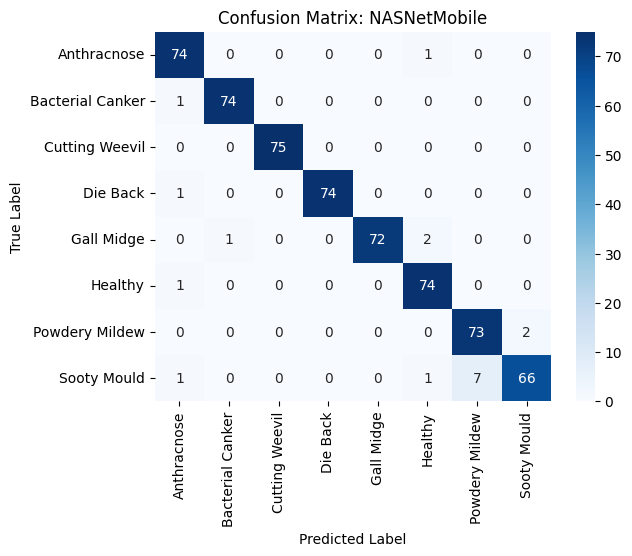

In [ ]:
# Test generator untuk NASNet
test_generator_nas = ImageDataGenerator(preprocessing_function=preprocess_nasnet).flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Prediksi dan label
y_pred_nas = nasnet_model.predict(test_generator_nas)
y_pred_classes_nas = np.argmax(y_pred_nas, axis=1)
y_true_nas = test_generator_nas.classes
class_labels = list(test_generator_nas.class_indices.keys())

# Report dan CM
print("📊 Classification Report: NASNetMobile")
print(classification_report(y_true_nas, y_pred_classes_nas, target_names=class_labels))

# Confusion Matrix
cm_nas = confusion_matrix(y_true_nas, y_pred_classes_nas)
sns.heatmap(cm_nas, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix: NASNetMobile")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


**perbandingan ukuran model**

In [ ]:
import os
import time

def get_model_size(model, model_name):
    model_path = f"{model_name}.h5"
    model.save(model_path, include_optimizer=False)
    size_mb = os.path.getsize(model_path) / (1024 * 1024)
    os.remove(model_path)
    return size_mb

size_mob = get_model_size(mobilenet_model, "mobilenet_model")
size_eff = get_model_size(efficientnet_model, "efficientnet_model")
size_nas = get_model_size(nasnet_model, "nasnet_model")

print(f"\n📦 Model Size:")
print(f"MobileNetV2     : {size_mob:.2f} MB")
print(f"EfficientNet-B0 : {size_eff:.2f} MB")
print(f"NASNetMobile    : {size_nas:.2f} MB")


📦 Model Size:
MobileNetV2     : 9.00 MB
EfficientNet-B0 : 15.94 MB
NASNetMobile    : 18.01 MB


**Perbandingan waktu inference**

In [ ]:
def measure_inference_time(model, generator, num_batches=10):
    start = time.time()
    batch_count = 0

    for x, _ in generator:
        _ = model.predict(x, verbose=0)
        batch_count += 1
        if batch_count >= num_batches:

            break

    end = time.time()
    total_images = batch_count * generator.batch_size
    avg_time_per_image = (end - start) / total_images
    return avg_time_per_image

time_mob = measure_inference_time(mobilenet_model, test_generator_mob)
time_eff = measure_inference_time(efficientnet_model, test_generator_eff)
time_nas = measure_inference_time(nasnet_model, test_generator_nas)

print(f"\n⏱️ Average Inference Time per Image:")
print(f"MobileNetV2     : {time_mob*1000:.2f} ms")
print(f"EfficientNet-B0 : {time_eff*1000:.2f} ms")
print(f"NASNetMobile    : {time_nas*1000:.2f} ms")



⏱️ Average Inference Time per Image:
MobileNetV2     : 20.67 ms
EfficientNet-B0 : 26.56 ms
NASNetMobile    : 71.68 ms
